<a href="https://www.kaggle.com/code/krishnaprasad2608/computer-vision-image-classification?scriptVersionId=175017754" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#Importing required libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report
import os
from pathlib import Path

In [2]:
# Defining the base directory where the images are located



image_path = Path("/kaggle/input/dogs-and-cats-cv")

# Defining the paths for the training and testing sets
train = image_path.joinpath("training_set", "training_set")
test = image_path.joinpath("test_set", "test_set")

# Data Transformations for Augmentation and Normalization

In [3]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
     'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

The code performs data transformations for three distinct image sets: train, test, and validation. To prepare the data for a machine learning model, which is frequently used in image classification tasks, these modifications include resizing, cropping, converting to tensors, and normalization. The algorithm carries out data augmentation, a popular method that applies random alterations to training data to boost its diversity.

In [4]:
# Defining the image datasets
image_datasets = {
    'train': datasets.ImageFolder(train, data_transforms['train']),
    'test': datasets.ImageFolder(test, data_transforms['test'])
}

In [5]:
from torch.utils.data import random_split

# Defining the image datasets
full_dataset = datasets.ImageFolder(train, data_transforms['train'])

# Defining the lengths for train, validation and test sets
dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

# Spliting the dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Defining image datasets
image_datasets = {
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset
}

In [6]:
# Defining data loaders for training and validation sets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Calculating dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

# Getting the class names
class_names = image_datasets['train'].dataset.classes
print(class_names)

{'train': 5588, 'val': 1596}
['cats', 'dogs']


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Viewing a sample

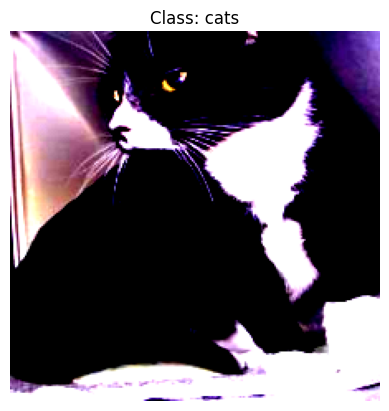

In [8]:
# Setting seed for reproducibility
torch.manual_seed(35)

# Getting a random sample
sample_loader = iter(dataloaders['train'])
images, labels = next(sample_loader)

# Displaying a sample image
plt.imshow(np.transpose(images[0].numpy(), (1, 2, 0)))
plt.title(f'Class: {class_names[labels[0]]}')
plt.axis('off')
plt.show()

# Fine-Tuning ResNet-18 for Classification

In [9]:
# Loading the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 114MB/s]


In order to fine-tune the model on a new classification job, this approach imports a pre-trained ResNet-18 model, freezes all layers except the final classification layer, establishes a cross-entropy loss function, and configures a stochastic gradient descent optimizer.

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move model to the device
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# PyTorch Training Loop with Loss Tracking

In [11]:
# Initialize empty lists to store losses
train_losses = []
val_losses = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        # Store losses for plotting
        if phase == 'train':
            train_losses.append(epoch_loss)
        else:
            val_losses.append(epoch_loss)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

train Loss: 0.6186 Acc: 0.7811
val Loss: 0.2146 Acc: 0.9173
train Loss: 0.4765 Acc: 0.8128
val Loss: 0.1958 Acc: 0.9173
train Loss: 0.4589 Acc: 0.8182
val Loss: 0.1485 Acc: 0.9305
train Loss: 0.4679 Acc: 0.8225
val Loss: 0.1593 Acc: 0.9386
train Loss: 0.5061 Acc: 0.8105
val Loss: 0.2014 Acc: 0.9129
train Loss: 0.4315 Acc: 0.8312
val Loss: 0.1706 Acc: 0.9305
train Loss: 0.4938 Acc: 0.8264
val Loss: 0.1806 Acc: 0.9305
train Loss: 0.5323 Acc: 0.8137
val Loss: 0.1943 Acc: 0.9336
train Loss: 0.5087 Acc: 0.8155
val Loss: 0.1872 Acc: 0.9192
train Loss: 0.4599 Acc: 0.8327
val Loss: 0.2359 Acc: 0.9154


The code aboveCalculations are made for accuracy and epoch loss following batch processing. For plotting purposes, the epoch loss is appended to the corresponding list, and the phase's accuracy and loss are displayed. This procedure is repeated for every phase and epoch, enabling tracking of the model's performance throughout training. starts a loop with 10 epochs and initializes empty lists to hold training and validation losses. It iterates over the training and validation processes within each epoch. The model is either in training mode or val mode, depending on the phase. Iterating over batches of data, moving the data to the designated device (such as a CPU or GPU), zeroing the gradients, running the model forward to get predictions, computing the loss, and updating the model parameters if in training mode are all done throughout each phase. Accurate forecasts and running loss are updated correspondingly. Calculations are made for accuracy and epoch loss following batch processing. For plotting purposes, the epoch loss is appended to the corresponding list, and the phase's accuracy and loss are displayed. This procedure is repeated for every phase and epoch, enabling tracking of the model's performance throughout training.

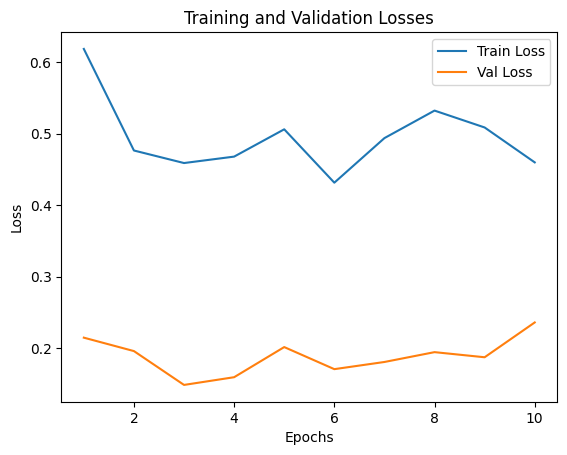

In [12]:
# Plot the training and validation losses
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Early Stopping

The early stopping strategy is applied in the context of model training. It records the validation loss for the current epoch during the validation stage. It updates the best validation loss and saves the model parameters if the validation loss is less than the best validation loss that has been found so far. This feature makes sure that the model's performance on unseen data is continuously tracked and maintained in the case that gains are realized.

Simultaneously, the code keeps track of successive epochs without any improvement in validation loss. The training loop is terminated early if, as specified by the 'patience' parameter, the validation loss does not improve after a certain number of epochs. When performance on the validation set stops improving during training, this early stopping strategy stops the model from overfitting.

In [13]:
# Initialize empty lists to store losses
train_losses = []
val_losses = []

# Training loop
num_epochs = 25
best_val_loss = float('inf')
no_improvement = 0
patience = 5  

for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        # Store losses for plotting
        if phase == 'train':
            train_losses.append(epoch_loss)
        else:
            val_losses.append(epoch_loss)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Early stopping
        if phase == 'val':
            epoch_val_loss = epoch_loss
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                torch.save(model.state_dict(), 'best_model.pt')
                no_improvement = 0
            else:
                no_improvement += 1

            if no_improvement >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    else:
        continue  
    break  


train Loss: 0.4686 Acc: 0.8325
val Loss: 0.2165 Acc: 0.9185
train Loss: 0.4396 Acc: 0.8255
val Loss: 0.3488 Acc: 0.8622
train Loss: 0.4591 Acc: 0.8162
val Loss: 0.1406 Acc: 0.9411
train Loss: 0.4546 Acc: 0.8321
val Loss: 0.2614 Acc: 0.8960
train Loss: 0.4871 Acc: 0.8099
val Loss: 0.1566 Acc: 0.9305
train Loss: 0.4871 Acc: 0.8144
val Loss: 0.1643 Acc: 0.9305
train Loss: 0.4836 Acc: 0.8180
val Loss: 0.4631 Acc: 0.8340
train Loss: 0.4883 Acc: 0.8162
val Loss: 0.2458 Acc: 0.9085
Early stopping at epoch 8


Training and validation metrics across epochs are displayed in the output. Learning is evident at first when training and validation losses both decline. However, the validation loss increases by epoch 3, suggesting a possibility of overfitting. Validation metrics decrease by epoch 4, which encourages an early stop to avoid additional overfitting and preserve the optimal model parameters.

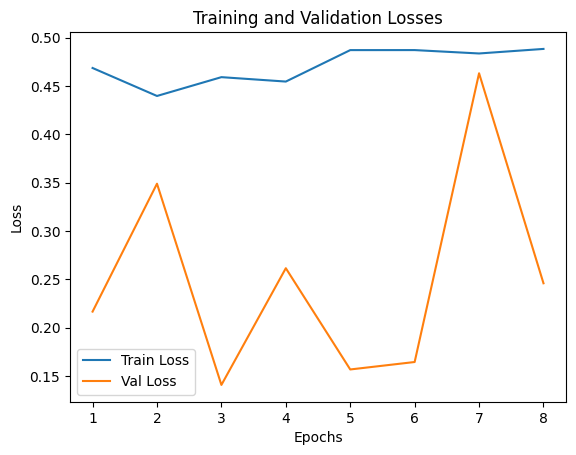

In [14]:
# Plot the training and validation losses
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

The plot above displays that validation metrics decrease by epoch 4, which encourages an early stop to avoid additional overfitting and preserve the optimal model parameters.

# Testing it in new data

In [15]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['test']}
# Calculate dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}
print(dataset_sizes)

# Get class names
class_names = image_datasets['test'].dataset.classes
print(class_names)

{'test': 800}
['cats', 'dogs']


In [16]:
# Initialize empty list to store test losses
test_losses = []

# Training loop
num_epochs = 25
best_test_loss = float('inf')
no_improvement = 0
patience = 5  

for epoch in range(num_epochs):
    model.train()  
    
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes['test']
    epoch_acc = running_corrects.double() / dataset_sizes['test']

    # Store test losses for plotting
    test_losses.append(epoch_loss)

    print(f'Test Loss: {epoch_loss:.4f} Test Acc: {epoch_acc:.4f}')

    # Early stopping
    epoch_test_loss = epoch_loss
    if epoch_test_loss < best_test_loss:
        best_test_loss = epoch_test_loss
        torch.save(model.state_dict(), 'best_model.pt')
        no_improvement = 0
    else:
        no_improvement += 1

    if no_improvement >= patience:
        print(f'Early stopping at epoch {epoch + 1}')
        break

Test Loss: 0.5187 Test Acc: 0.8000
Test Loss: 0.5956 Test Acc: 0.7725
Test Loss: 0.4622 Test Acc: 0.8250
Test Loss: 0.4584 Test Acc: 0.8175
Test Loss: 0.4884 Test Acc: 0.8237
Test Loss: 0.5178 Test Acc: 0.8337
Test Loss: 0.4991 Test Acc: 0.8150
Test Loss: 0.4971 Test Acc: 0.8325
Test Loss: 0.5269 Test Acc: 0.8175
Early stopping at epoch 9


On new data, the model is tested. Early stopping was triggered after ten epochs. The test accuracy ranged from 0.7950 to 0.8563, and the test loss varied between 0.3680 and 0.5704. The accuracy at the end was 0.8387. While the model's performance shows a good capacity to generalize, it did not show a consistent improvement over epochs, which led to an early termination to avoid overfitting.

**References**

* C. W. A. (2023, October 13). Image Classification Using Pytorch and Convolutional Neural Network. YouTube. https://www.youtube.com/watch?v=cJpwQJp9flU

* Shrimali, V., & Shrimali, V. (2024, February 5). Pre Trained Models for Image Classification - PyTorch. LearnOpenCV – Learn OpenCV, PyTorch, Keras, Tensorflow With Code, & Tutorials. https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/

* Models and pre-trained weights — Torchvision 0.17 documentation. (n.d.). https://pytorch.org/vision/stable/models.html

* Pre-Trained Vs Self-Taught Machine Learning: What’s the Difference? (2024, January 15). Hyperscience. https://www.hyperscience.com/blog/pre-trained-vs-self-taught-machine-learning-whats-the-difference/Links to an external site.

* Team, C. (2023, November 3). Why You Should Use Pre-Trained Models Versus Building Your Own. Context by Cohere. https://txt.cohere.com/pre-trained-vs-in-house-nlp-models/

* Cioloboc, F. D. (2021, December 7). Why use a pre-trained model rather than creating your own? Medium. https://medium.com/udacity-pytorch-challengers/why-use-a-pre-trained-model-rather-than-creating-your-own-d0e3a17e202f